* full connection을 이용한 basic autoencoder
* cross entropy->sigmoid로

## 00. Importing Modules

In [1]:
import tensorflow as tf
import numpy as np
import os

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


##  01. Input MNIST dataset

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

datasets = input_data.read_data_sets('/Users/urim/Data/MNIST_data/', one_hot=True)

Extracting /Users/urim/Data/MNIST_data/train-images-idx3-ubyte.gz
Extracting /Users/urim/Data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /Users/urim/Data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /Users/urim/Data/MNIST_data/t10k-labels-idx1-ubyte.gz


## 02. Creating Exploring_datasets function

In [3]:
import matplotlib.pyplot as plt

def Exploring_datasets(dataSets, datanum=10, reshape_size=[28,28]):
    print('# dataset shape')
    print('train image shape: {} \ttrain label shape: {}'
          .format(dataSets.train.images.shape, dataSets.train.labels.shape))
    print('val image shape: {} \t\tval label shape: {}'
          .format(dataSets.validation.images.shape, dataSets.validation.labels.shape))
    print('test image shape: {} \t\ttest label shape: {}'.format(dataSets.test.images.shape, dataSets.test.labels.shape))

    print('\n# data shape')
    print('train image shape: ',dataSets.train.images[1].shape) #(784,)
    print('train image reshape: ',dataSets.train.images[1].reshape(28,28).shape) #(28,28)
    print('train label one_hot: ',dataSets.train.labels[1])
    print('train label true value: ',np.argmax(dataSets.train.labels[1]))

    print('\n# 10 train images and true value')
    plt.figure(figsize=(10,10))
    for i in range(datanum):
        plt.subplot(1,datanum,i+1),
        plt.imshow(dataSets.train.images[i].reshape(reshape_size), cmap='gray')
        plt.title(np.argmax(dataSets.train.labels[i]))

## 03. Exploring MNIST dataset

# dataset shape
train image shape: (55000, 784) 	train label shape: (55000, 10)
val image shape: (5000, 784) 		val label shape: (5000, 10)
test image shape: (10000, 784) 		test label shape: (10000, 10)

# data shape
train image shape:  (784,)
train image reshape:  (28, 28)
train label one_hot:  [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
train label true value:  3

# 10 train images and true value


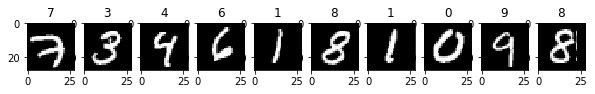

In [4]:
%matplotlib inline
#from dl_utils import Exploring_datasets as EP_datasets

Exploring_datasets(dataSets=datasets, datanum=10, reshape_size=[28,28])

## 04. Building dl_ops

In [5]:
def lrelu(x, leak=0.2):
    return tf.maximum(x, x*leak)

def linear(input_, output_size, scope=None):
    input_shape = input_.get_shape().as_list()
    stddev = 1.0/np.sqrt(output_size)
    with tf.variable_scope(scope):
        matrix = tf.get_variable('Matrix', shape=[input_shape[1], output_size], initializer=tf.random_normal_initializer(stddev=stddev)) #tf.float32 뺴먹음
        bias = tf.get_variable('bias', shape=[output_size], initializer=tf.constant_initializer()) #0.0
        return tf.matmul(input_, matrix) + bias
    
def accuracy(pred, true):
    is_correct = tf.equal(tf.argmax(pred, 1), tf.argmax(true, 1))
    return tf.reduce_mean(tf.cast(is_correct, tf.float32))

## 05. Building dl_utils

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def loss_viewer(train_step, loss_dict, view_step=500, figsize=(15,5)):
    color_list=['r-','b-','g-']
    plt.figure(figsize=figsize)
    for idx, (key, value) in enumerate(loss_dict.items()):
        plt.plot(np.arange(train_step+1)[-view_step:]+1, value[-view_step:], color_list[idx], label=key)
    plt.grid(True)
    plt.axvline(x=max(0, train_step-view_step+1), color='k')
    plt.axhline(y=0, color='k')
    plt.title('Loss for recent {} steps'.format(view_step, size=20))
    plt.legend()
    plt.show()

## 06. Building dl_model

In [7]:
class MLP:
    def __init__(self, graph, datasets, flag):
        self.graph = graph
        self.flag = flag
        self.datasets = datasets
        self.tensordict = dict()
        self.resultdict = dict()
        self.summarytensordict = dict()
        self.BuildingGraph()
        
    def _BuildingRepertory(self, flag):
        self.tensordict['inputs'] = tf.placeholder(tf.float32, shape=[flag.batch_size, flag.height_size*flag.width_size*flag.channel_size])
        self.tensordict['labels'] = tf.placeholder(tf.float32, shape=[flag.batch_size, flag.label_size])
        self.tensordict['global_step'] = tf.Variable(0, name='global_step', trainable=False, dtype=tf.int32)
        self.tensordict['lr'] = tf.train.exponential_decay(flag.lr, self.tensordict['global_step'], 
                                                           flag.decay_steps, flag.decay_rate, staircase=True)
        
    def _Inference_AE(self, flag):
        #Encoding
        fc1_e = lrelu(linear(self.tensordict['inputs'], flag.hidden_size, 'fc1_encoding')) #Bx784 -> Bx64
        fc2_e = lrelu(linear(fc1_e, int(flag.hidden_size/2), 'fc2_encoding')) #Bx64 -> Bx32
        
        #Decoding
        fc3_d = lrelu(linear(fc2_e, int(flag.hidden_size), 'fc3_decoding')) #Bx32 -> Bx64
        fc4_d = linear(fc3_d, flag.height_size*flag.width_size*flag.channel_size, 'fc4_decoding') #Bx64 -> Bx784
        self.tensordict['decoder'] = fc4_d
        
        self.tensordict['generated'] = tf.nn.sigmoid(self.tensordict['decoder'])
        
    def _Loss_AE(self, scope_name): 
        with tf.name_scope(scope_name) as scope:
            loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=self.tensordict['decoder'], labels=self.tensordict['inputs'])
            tf.add_to_collection(scope, tf.reduce_mean(loss))
            _losses = tf.get_collection(scope)
            self.tensordict['loss'] = tf.add_n(_losses, name='total_'+scope_name+'_per_batch')
            
    def _Eval_AE(self, flag):
        self.tensordict['pred'] = lrelu(self.tensordict['pred_logits'])
        self.tensordict['accuracy'] = accuracy(tf.nn.softmax(self.tensordict['pred']), self.tensordict['labels'])
        
    def BuildingGraph(self):
        with self.graph.as_default():
            self._BuildingRepertory(self.flag)
            self._Inference_AE(self.flag)
            self._Loss_AE('loss')
            opt_dict = {'GD':tf.train.GradientDescentOptimizer, 'ADAM':tf.train.AdamOptimizer}
            optimizer = opt_dict[self.flag.optimizer](self.tensordict['lr'])
            self.tensordict['train_opt'] = optimizer.minimize(self.tensordict['loss'])
            #self._Eval_AE(self.flag)
            self._saver = tf.train.Saver()
            
    def _SaveModel(self, sess):
        modelPath = os.path.join(self.flag.checkpoint_dir, self.flag.model_name+'_'+str(self.flag.batch_size))
        self._saver.save(sess, os.path.join(modelPath, self.flag.model_name), global_step=self.tensordict['global_step'])
        print(" [*] Saving checkpoints... {}".format(os.path.join(modelPath, self.flag.model_name)))
        
    def _LoadModel(self, sess):
        modelPath = os.path.join(self.flag.checkpoint_dir, self.flag.model_name+'_'+str(self.flag.batch_size))
        print(" [*] Reading checkpoints... {}".format(modelPath))
        ckpt = tf.train.get_checkpoint_state(modelPath)
        
        self._saver.restore(sess, ckpt.model_checkpoint_path)
        
    
    def Train(self):
        from tqdm import trange
        with tf.Session(graph=self.graph) as sess:
            print("\Launching tf_graph..")
            tf.train.start_queue_runners(sess=sess)
            self.summarytensordict['train_writer'] = tf.summary.FileWriter(self.flag.checkpoint_dir+'/TRAIN', self.graph)
            tf.global_variables_initializer().run(session=sess)
            
            average_tr_loss = 0
            average_val_loss = 0
            loss_dict = {'train_loss':[], 'val_loss':[]}
            for step in trange(self.flag.train_steps):
                ## train
                tr_inputs, tr_labels = self.datasets.train.next_batch(self.flag.batch_size)
                tr_feed_dict = {self.tensordict['inputs']:tr_inputs, self.tensordict['labels']:tr_labels}
                _, tr_loss, g_step, lr = sess.run([self.tensordict['train_opt'], self.tensordict['loss'], 
                                                           self.tensordict['global_step'],
                                                           self.tensordict['lr']], feed_dict=tr_feed_dict)
                
                average_tr_loss += tr_loss
                loss_dict['train_loss'].append(tr_loss)
                
                ## validation
                val_inputs, val_labels = self.datasets.validation.next_batch(self.flag.batch_size)
                val_feed_dict = {self.tensordict['inputs']:val_inputs, self.tensordict['labels']:val_labels}
                val_loss = sess.run(self.tensordict['loss'], feed_dict=val_feed_dict)
                average_val_loss += val_loss
                loss_dict['val_loss'].append(val_loss)
                
                if step % self.flag.printby == 0:
                    if step > 0:
                        average_tr_loss /= self.flag.printby
                        average_val_loss /= self.flag.printby
                    print('step: {}, average_loss: {}, LR: {}'.format(g_step, average_tr_loss, lr))
                    print('\tAverage val_loss: {}'.format(average_val_loss))
                    #print('\ttr_acc: {0:.2f} val_acc: {1:.2f}'.format(tr_acc, val_acc))
                    average_tr_loss = 0
                    average_val_loss = 0
                    
                if ((step+1)%(self.flag.printby)==0)&(step>0):
                    loss_viewer(step, loss_dict, view_step=self.flag.printby)
                    
            # save checkpoint        
            self._SaveModel(sess)
            
                    
    def Test(self):
        with tf.Session(graph=self.graph) as sess:
            tf.train.start_queue_runners(sess=sess)
            self.summarytensordict['test_writer'] = tf.summary.FileWriter(self.flag.checkpoint_dir+'/TEST', self.graph)
            tf.global_variables_initializer().run(session=sess)
            
            self._LoadModel(sess)
            print("\t[*] Load SUCCESS")
            
            for step in range(self.flag.train_steps):
                ## train
                te_inputs, te_labels = self.datasets.test.next_batch(self.flag.batch_size)
                te_feed_dict = {self.tensordict['inputs']:te_inputs, self.tensordict['labels']:te_labels}
                te_loss = sess.run(self.tensordict['loss'], feed_dict=te_feed_dict)
            #print('test accuracy: {} test loss: {}'.format(te_acc, te_loss))
            print('test loss: {}'.format(te_loss))
            
            #Output_visualizing
            self.inputs, self.generated, self.labels = sess.run([self.tensordict['inputs'], self.tensordict['generated'], 
                                                                self.tensordict['labels']], feed_dict=te_feed_dict)
            
    def OutputVisualization(self, figsize=[28,28], print_num=8):  
        import numpy as np
        plt.figure(figsize=figsize)
        for i in range(print_num):
            plt.subplot(print_num,2,2*i+1)
            plt.imshow(self.inputs[i,:].reshape(28,28), cmap='gray')     
            if i in [0]:
                plt.title('inputs', fontsize=20)
                plt.title(np.argmax(self.labels[i]))

            plt.subplot(print_num,2,2*i+2)
            plt.imshow(self.generated[i,:].reshape(28,28), cmap='gray')
            if i in [0]:
                plt.title('generated_outputs', fontsize=20)
            

## 07. Building PIPELINE

In [8]:
class PIPELINE:
    def __init__(self, datasets, flag_list):
        self.datasets = datasets
        self.flag_list = flag_list
        self.BuildingGraph()
        
    def BuildingGraph(self):
        model_dict = {'MLP': MLP}
        self._graph_list = [tf.Graph() for i in range(len(self.flag_list))]
        self.model_list = [model_dict[f.model](g, self.datasets, f) for g, f in zip(self._graph_list, self.flag_list)]
        for model_idx, f in enumerate(self.flag_list):
            print("\nModel_{}: {}".format(model_idx, f.model_name))
        
    def Training_model(self, model_idx):
        model_train_queue = [self.model_list[model_idx]]
        for idx, model in enumerate(model_train_queue):
            print("\nModel_{}: {}\nTrianing START!".format(idx, model.flag.model_name))
            model.Train()
            
    def Testing_model(self, model_idx):
        model_test_queue = [self.model_list[model_idx]]
        for idx, model in enumerate(model_test_queue):
            print("\nModel_{}: {}\nTesting START!".format(idx, model.flag.model_name))
            model.Test()
            
    def Visualizing_model(self, model_idx):
        model_visualize_queue = [self.model_list[model_idx]]
        for idx, model in enumerate(model_visualize_queue):
            print("\nModel_{}: {}\nVisualizing START!".format(idx, model.flag.model_name))
            model.OutputVisualization()

## 08. Setting the basic hyperparameters

In [9]:
class Model_Flag:
    def __init__(self, model, model_name, filePath='./Results'):
        self.model = model
        self.model_name = model_name
        
        self.hidden_size = 256
        self.label_size = 10
        self.channel_size = 1
        self.batch_size = 32
        self.lr = 0.5
        self.optimizer = 'GD' # or 'ADAM'
        self.decay_steps = 10000
        self.decay_rate = 0.9
        self.train_steps = 10000
        self.printby = 1000
        self.printlossby = 200
        self.saveby = 100
        self.checkpoint_dir = filePath+'/'+self.model_name+'/chechpoint/'

## 09. Setting the hyperparameters by model

In [10]:
# MLP_AE (B, T, F, C) = (32, 28, 28, 1)
model_flag1 = Model_Flag(model='MLP', model_name='MLP_AE')

model_flag1.height_size = 28
model_flag1.width_size = 28

# flag_list
model_flag_list = [model_flag1]

## 10. Running PIPELINE

In [11]:
seq_analyzer = PIPELINE(datasets, model_flag_list)


Model_0: MLP_AE



Model_0: MLP_AE
Trianing START!
\Launching tf_graph..


  0%|          | 12/10000 [00:00<25:45,  6.46it/s]

step: 0, average_loss: 0.6951055526733398, LR: 0.5
	Average val_loss: 0.6945624947547913


 10%|▉         | 994/10000 [00:09<00:59, 151.73it/s]

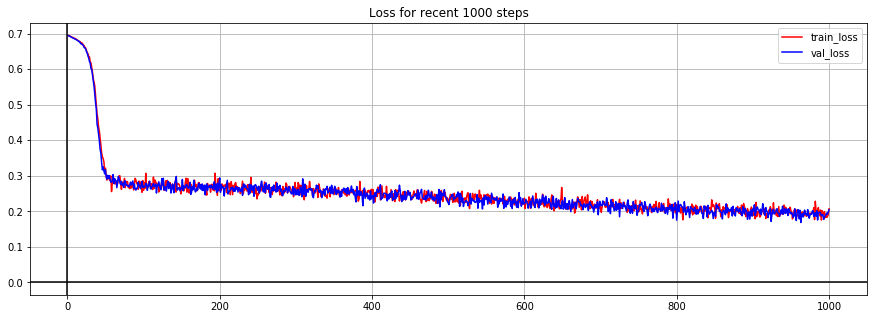

 10%|█         | 1027/10000 [00:10<01:29, 100.81it/s]

step: 0, average_loss: 0.25310947908461096, LR: 0.5
	Average val_loss: 0.2513069512248039


 20%|█▉        | 1987/10000 [00:17<01:07, 119.07it/s]

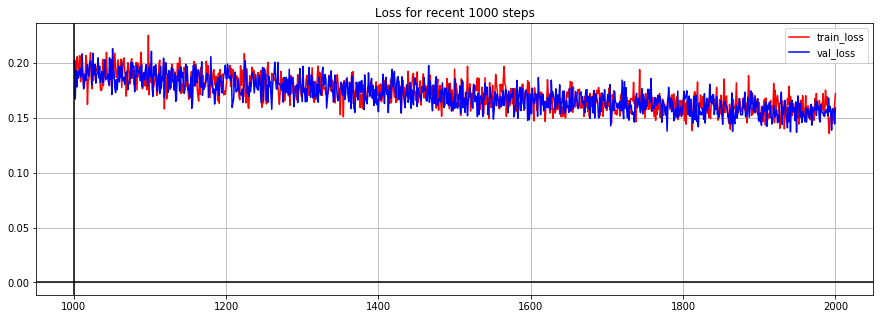

 20%|██        | 2028/10000 [00:17<01:24, 94.01it/s] 

step: 0, average_loss: 0.17200323490798472, LR: 0.5
	Average val_loss: 0.17077295212447643


 30%|██▉       | 2985/10000 [00:24<00:53, 132.35it/s]

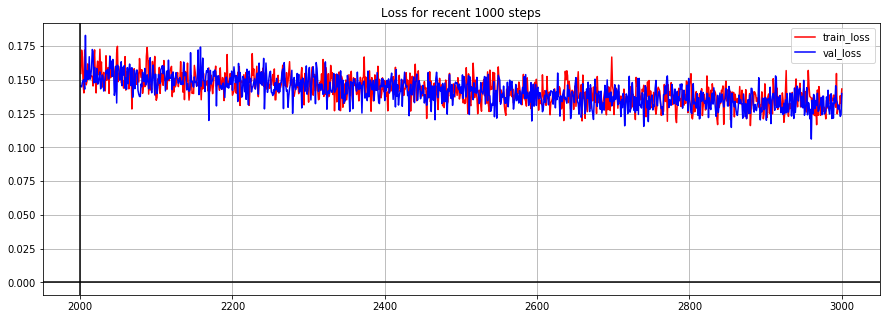

 30%|███       | 3032/10000 [00:25<01:08, 101.88it/s]

step: 0, average_loss: 0.1424850521311164, LR: 0.5
	Average val_loss: 0.14156858294457197


 40%|███▉      | 3994/10000 [00:32<00:48, 123.50it/s]

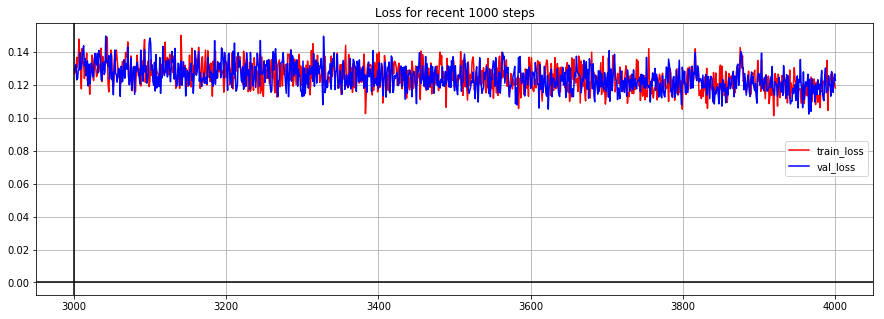

 40%|████      | 4021/10000 [00:32<01:27, 68.02it/s] 

step: 0, average_loss: 0.12506027560681104, LR: 0.5
	Average val_loss: 0.12471084062755108


 50%|████▉     | 4997/10000 [00:42<00:34, 145.10it/s]

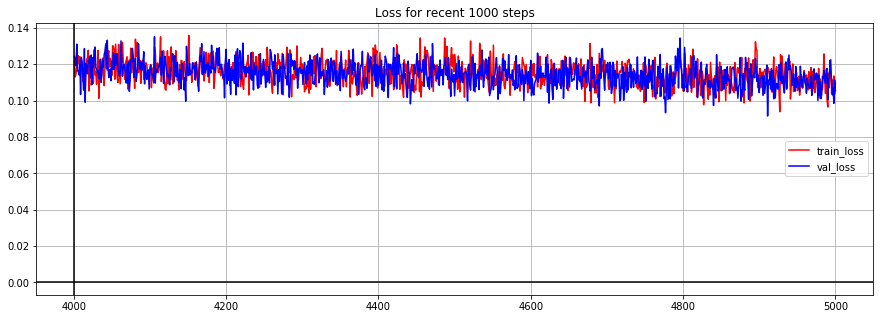

 50%|█████     | 5012/10000 [00:43<01:10, 70.53it/s] 

step: 0, average_loss: 0.1151518394574523, LR: 0.5
	Average val_loss: 0.11450329926609994


 60%|█████▉    | 5991/10000 [00:50<00:27, 148.10it/s]

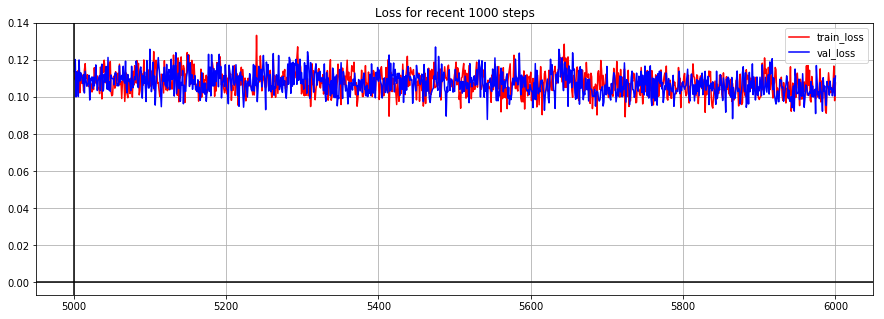

 60%|██████    | 6021/10000 [00:50<00:50, 78.95it/s] 

step: 0, average_loss: 0.10794136091321707, LR: 0.5
	Average val_loss: 0.10747678225487471


 70%|██████▉   | 6991/10000 [00:58<00:30, 97.66it/s] 

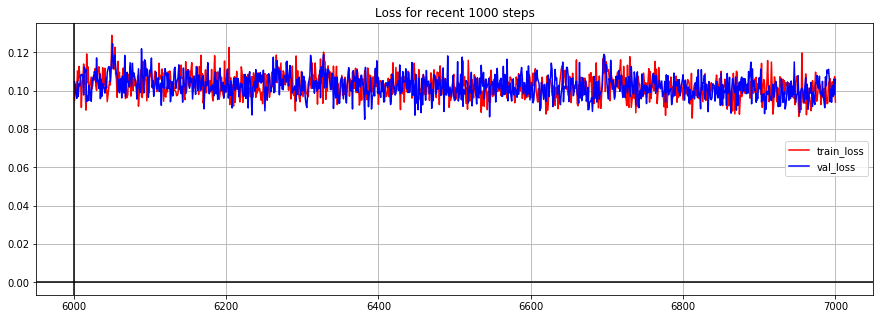

 70%|███████   | 7012/10000 [00:59<00:53, 55.34it/s]

step: 0, average_loss: 0.10261590453237295, LR: 0.5
	Average val_loss: 0.10242566946148872


 80%|███████▉  | 7986/10000 [01:07<00:13, 148.59it/s]

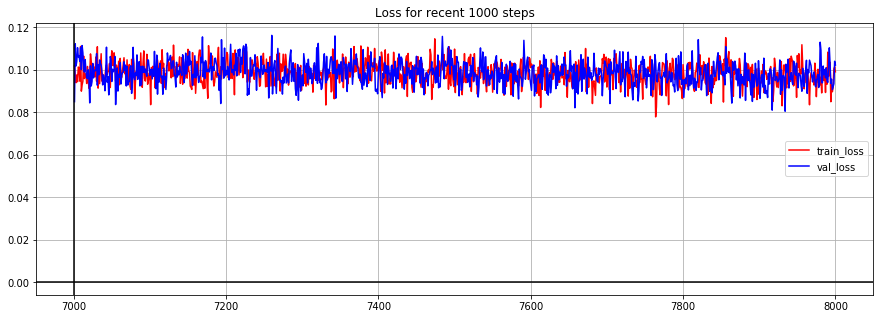

 80%|████████  | 8015/10000 [01:08<00:21, 92.48it/s] 

step: 0, average_loss: 0.09855335721373558, LR: 0.5
	Average val_loss: 0.09860984030365944


 90%|████████▉ | 8992/10000 [01:14<00:06, 156.16it/s]

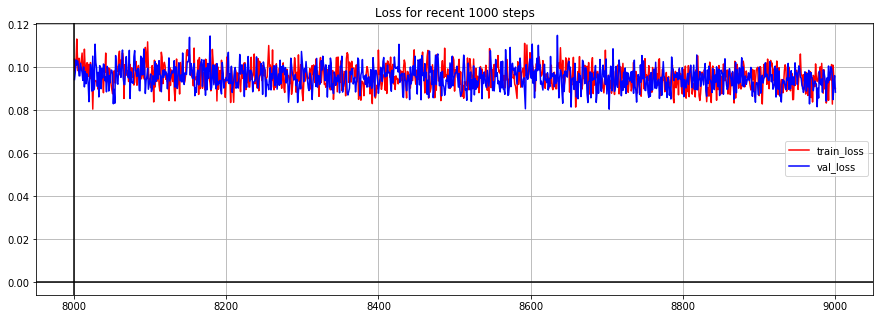

 90%|█████████ | 9020/10000 [01:15<00:12, 75.98it/s] 

step: 0, average_loss: 0.09578043358772993, LR: 0.5
	Average val_loss: 0.09533061161637306


100%|█████████▉| 9987/10000 [01:22<00:00, 122.37it/s]

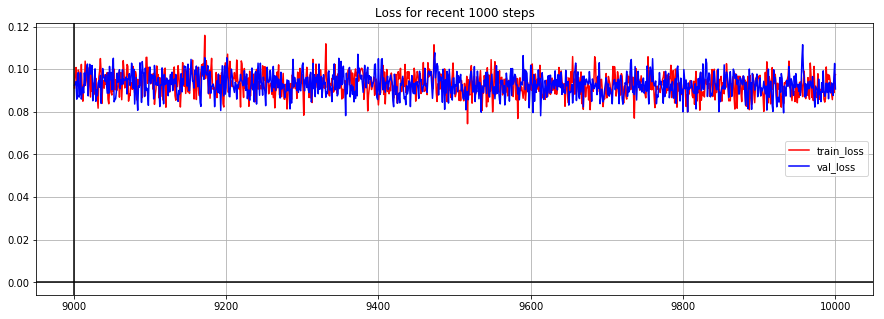

100%|██████████| 10000/10000 [01:23<00:00, 120.01it/s]


 [*] Saving checkpoints... ./Results/MLP_AE/chechpoint/MLP_AE_32/MLP_AE


In [12]:
seq_analyzer.Training_model(0)

In [14]:
seq_analyzer.Testing_model(0)


Model_0: MLP_AE
Testing START!
 [*] Reading checkpoints... ./Results/MLP_AE/chechpoint/MLP_AE_32
INFO:tensorflow:Restoring parameters from ./Results/MLP_AE/chechpoint/MLP_AE_32/MLP_AE-0
	[*] Load SUCCESS
test loss: 0.08958110958337784



Model_0: MLP_AE
Visualizing START!


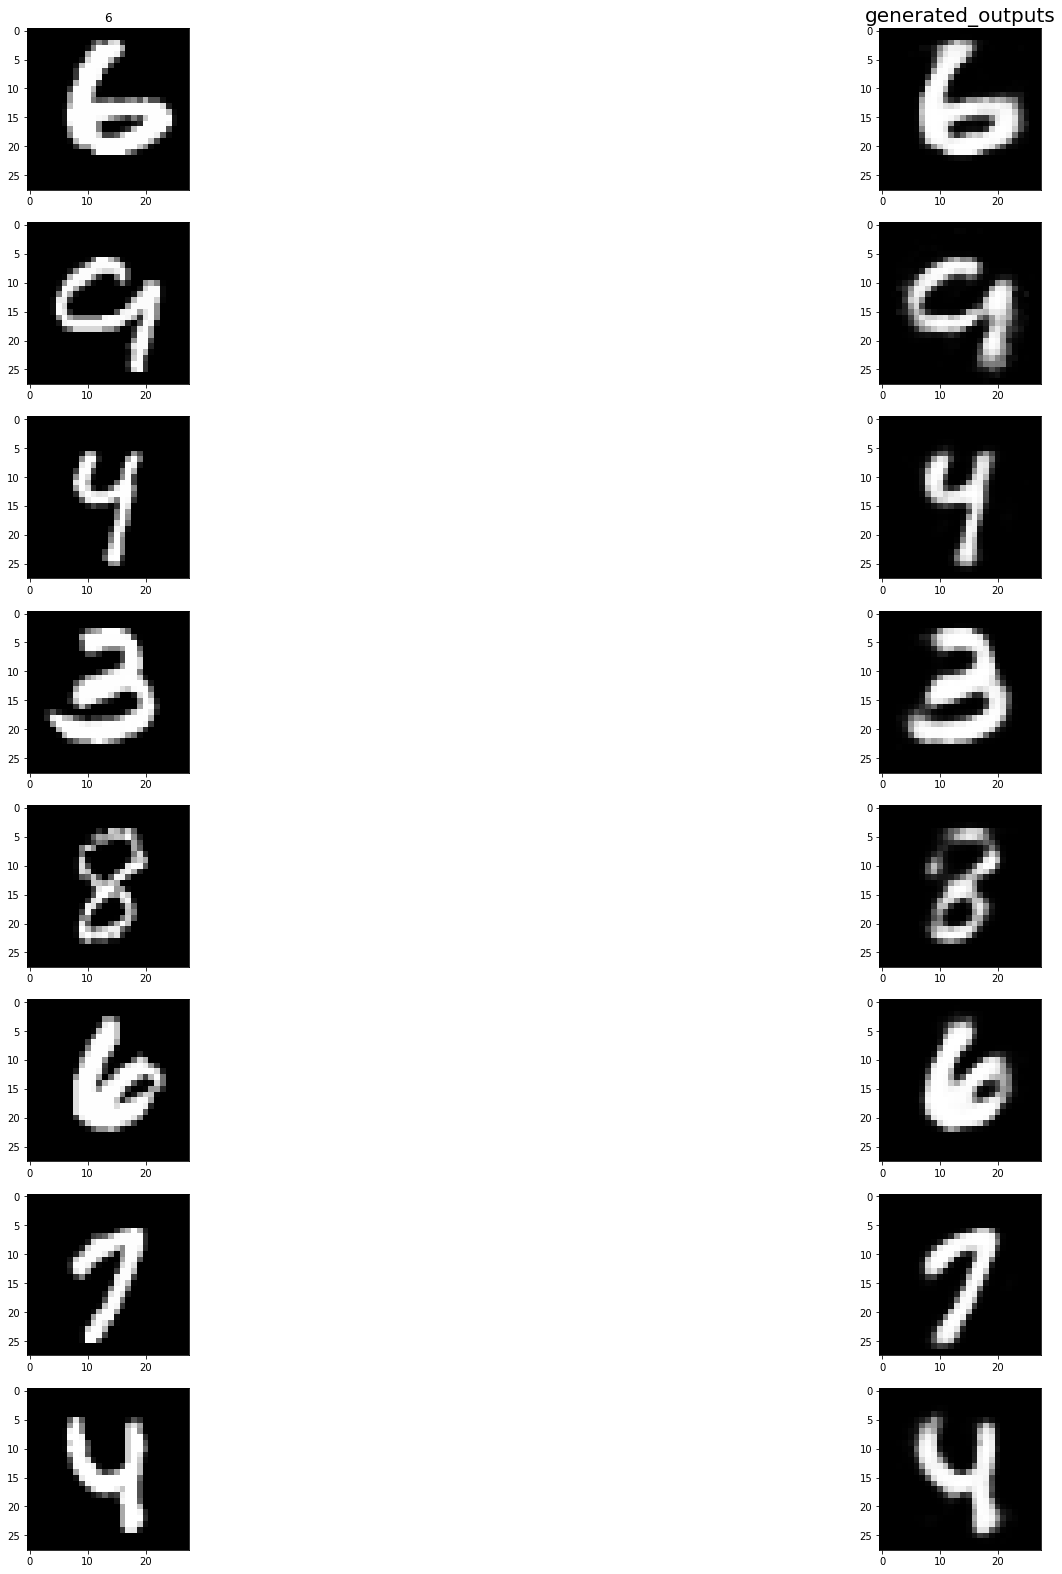

In [15]:
seq_analyzer.Visualizing_model(0)